### Why LSTM?
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs.

In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [268]:
# Load dataset

data = pd.read_csv("municipality_bus_utilization.csv") 
data

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113


### Why we can train and test each municipality separately?
All municipalities usage or their total capacity are independent from each other and we have just 10 municipality that we can easily analyse their data one by one. Here let's just pick municipality number 9 as an example.

In [269]:
data['Indicator'] = np.nan
data

,timestamp,municipality_id,usage,total_capacity,Indicator
0,2017-06-04 07:59:42,9,454,1332,NaN
1,2017-06-04 07:59:42,8,556,2947,NaN
2,2017-06-04 07:59:42,4,1090,3893,NaN
3,2017-06-04 07:59:42,0,204,2813,NaN
4,2017-06-04 07:59:42,7,718,2019,NaN
...,...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697,NaN
13066,2017-08-19 16:30:35,8,1193,2947,NaN
13067,2017-08-19 16:30:35,7,1354,2019,NaN
13068,2017-08-19 16:30:35,6,1680,3113,NaN


In [270]:
row = 0
count = 1
for i in range(len(data)):
    if data.iloc[i, 1] == 9:
        data.iloc[i, 4] = 9
        row = row + 1
        count = count + 1  
data

,timestamp,municipality_id,usage,total_capacity,Indicator
0,2017-06-04 07:59:42,9,454,1332,9.0
1,2017-06-04 07:59:42,8,556,2947,NaN
2,2017-06-04 07:59:42,4,1090,3893,NaN
3,2017-06-04 07:59:42,0,204,2813,NaN
4,2017-06-04 07:59:42,7,718,2019,NaN
...,...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697,NaN
13066,2017-08-19 16:30:35,8,1193,2947,NaN
13067,2017-08-19 16:30:35,7,1354,2019,NaN
13068,2017-08-19 16:30:35,6,1680,3113,NaN


In [271]:
data = data.dropna()
data.reset_index(drop=True, inplace=True)
data

,timestamp,municipality_id,usage,total_capacity,Indicator
0,2017-06-04 07:59:42,9,454,1332,9.0
1,2017-06-04 08:25:42,9,487,1332,9.0
2,2017-06-04 08:59:42,9,527,1332,9.0
3,2017-06-04 09:32:46,9,599,1332,9.0
4,2017-06-04 09:59:48,9,666,1332,9.0
...,...,...,...,...,...
1302,2017-08-19 14:30:33,9,983,1332,9.0
1303,2017-08-19 15:03:34,9,976,1332,9.0
1304,2017-08-19 15:29:33,9,954,1332,9.0
1305,2017-08-19 16:03:35,9,879,1332,9.0


##### Each 2 rows are inside of 1 hour  and we need the maximum of them

In [272]:
df_max = data.groupby(np.arange(len(data))//2).max()
print(df_max)

               timestamp  municipality_id  usage  total_capacity  Indicator
0    2017-06-04 08:25:42                9    487            1332        9.0
1    2017-06-04 09:32:46                9    599            1332        9.0
2    2017-06-04 10:26:49                9    724            1332        9.0
3    2017-06-04 11:25:47                9    829            1332        9.0
4    2017-06-04 12:29:45                9    845            1332        9.0
..                   ...              ...    ...             ...        ...
649  2017-08-19 13:03:30                9    896            1332        9.0
650  2017-08-19 14:03:31                9    979            1332        9.0
651  2017-08-19 15:03:34                9    983            1332        9.0
652  2017-08-19 16:03:35                9    954            1332        9.0
653  2017-08-19 16:30:35                9    815            1332        9.0

[654 rows x 5 columns]


##### This is how our data finally looks

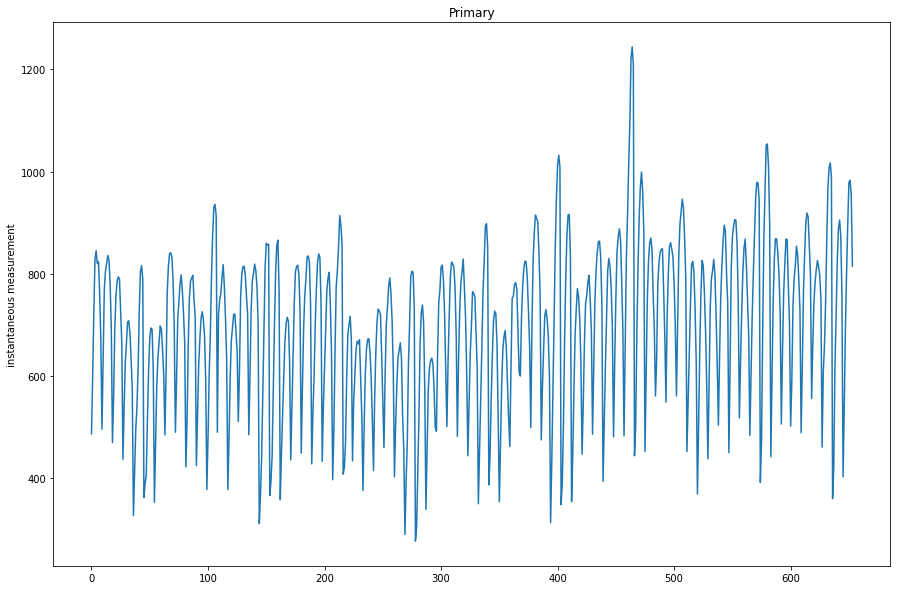

In [273]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(df_max.usage)
plt.title('Primary')
plt.ylabel('instantaneous measurement')
#plt.xlabel('Time')
#plt.xlim([7000,12000])
plt.show()

##### Preparing data for the Network

In [274]:
data2 = df_max[['timestamp', 'usage']]
data2 = data2.set_index('timestamp')
data2

,usage
timestamp,
2017-06-04 08:25:42,487
2017-06-04 09:32:46,599
2017-06-04 10:26:49,724
2017-06-04 11:25:47,829
2017-06-04 12:29:45,845
...,...
2017-08-19 13:03:30,896
2017-08-19 14:03:31,979
2017-08-19 15:03:34,983


In [275]:
df1 = data2.values
df1 = df1.astype('float32')
print(df1)

[[ 487.]
 [ 599.]
 [ 724.]
 [ 829.]
 [ 845.]
 [ 820.]
 [ 824.]
 [ 762.]
 [ 673.]
 [ 496.]
 [ 635.]
 [ 770.]
 [ 805.]
 [ 820.]
 [ 836.]
 [ 827.]
 [ 780.]
 [ 694.]
 [ 470.]
 [ 559.]
 [ 692.]
 [ 758.]
 [ 786.]
 [ 794.]
 [ 790.]
 [ 730.]
 [ 665.]
 [ 437.]
 [ 540.]
 [ 626.]
 [ 666.]
 [ 706.]
 [ 708.]
 [ 684.]
 [ 633.]
 [ 573.]
 [ 327.]
 [ 410.]
 [ 497.]
 [ 539.]
 [ 616.]
 [ 727.]
 [ 804.]
 [ 816.]
 [ 790.]
 [ 362.]
 [ 390.]
 [ 406.]
 [ 515.]
 [ 610.]
 [ 674.]
 [ 694.]
 [ 691.]
 [ 613.]
 [ 353.]
 [ 462.]
 [ 580.]
 [ 635.]
 [ 666.]
 [ 698.]
 [ 691.]
 [ 650.]
 [ 603.]
 [ 485.]
 [ 608.]
 [ 764.]
 [ 815.]
 [ 840.]
 [ 841.]
 [ 833.]
 [ 788.]
 [ 698.]
 [ 490.]
 [ 594.]
 [ 711.]
 [ 747.]
 [ 780.]
 [ 798.]
 [ 766.]
 [ 720.]
 [ 666.]
 [ 422.]
 [ 510.]
 [ 658.]
 [ 753.]
 [ 786.]
 [ 792.]
 [ 797.]
 [ 749.]
 [ 715.]
 [ 425.]
 [ 525.]
 [ 622.]
 [ 671.]
 [ 712.]
 [ 726.]
 [ 710.]
 [ 679.]
 [ 593.]
 [ 378.]
 [ 479.]
 [ 603.]
 [ 682.]
 [ 797.]
 [ 878.]
 [ 930.]
 [ 936.]
 [ 914.]
 [ 490.]
 [ 720.]
 [ 749.]
 

In [276]:
# Normalize the dataset

scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)
print(df1)

[[0.21716648]
 [0.33298862]
 [0.4622544 ]
 [0.5708376 ]
 [0.5873836 ]
 [0.5615305 ]
 [0.565667  ]
 [0.50155115]
 [0.40951395]
 [0.22647363]
 [0.37021714]
 [0.5098242 ]
 [0.5460186 ]
 [0.5615305 ]
 [0.57807654]
 [0.5687694 ]
 [0.52016544]
 [0.4312306 ]
 [0.19958633]
 [0.2916236 ]
 [0.42916232]
 [0.49741465]
 [0.5263702 ]
 [0.53464323]
 [0.53050673]
 [0.46845913]
 [0.40124094]
 [0.16546017]
 [0.27197516]
 [0.36091   ]
 [0.4022751 ]
 [0.4436401 ]
 [0.4457084 ]
 [0.42088932]
 [0.36814892]
 [0.30610132]
 [0.05170631]
 [0.13753876]
 [0.22750777]
 [0.27094102]
 [0.35056877]
 [0.46535677]
 [0.54498446]
 [0.55739397]
 [0.53050673]
 [0.08790073]
 [0.11685625]
 [0.13340226]
 [0.246122  ]
 [0.344364  ]
 [0.4105481 ]
 [0.4312306 ]
 [0.42812824]
 [0.3474664 ]
 [0.07859358]
 [0.19131333]
 [0.31334025]
 [0.37021714]
 [0.4022751 ]
 [0.4353671 ]
 [0.42812824]
 [0.38572907]
 [0.33712512]
 [0.21509826]
 [0.34229577]
 [0.50361943]
 [0.5563599 ]
 [0.58221304]
 [0.5832471 ]
 [0.5749741 ]
 [0.52843845]
 [0.43

In [277]:
# Split into train and test sets (more than 2 weeks selected as test data)

train_size = int(len(df1) * 0.95)
test_size = len(df1) - train_size
train, test = df1[0:train_size,:], df1[train_size:len(df1),:]
print(len(train), len(test))

621 33


In [278]:
# Convert an array of values into a dataset matrix

def create_dataset(df1, look_back=1):
    dataX, dataY = [], []
    for i in range(len(df1)-look_back-1):
        a = df1[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(df1[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [280]:
# Reshape into X=t and Y=t+1

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainY)

[0.33298862 0.4622544  0.5708376  0.5873836  0.5615305  0.565667
 0.50155115 0.40951395 0.22647363 0.37021714 0.5098242  0.5460186
 0.5615305  0.57807654 0.5687694  0.52016544 0.4312306  0.19958633
 0.2916236  0.42916232 0.49741465 0.5263702  0.53464323 0.53050673
 0.46845913 0.40124094 0.16546017 0.27197516 0.36091    0.4022751
 0.4436401  0.4457084  0.42088932 0.36814892 0.30610132 0.05170631
 0.13753876 0.22750777 0.27094102 0.35056877 0.46535677 0.54498446
 0.55739397 0.53050673 0.08790073 0.11685625 0.13340226 0.246122
 0.344364   0.4105481  0.4312306  0.42812824 0.3474664  0.07859358
 0.19131333 0.31334025 0.37021714 0.4022751  0.4353671  0.42812824
 0.38572907 0.33712512 0.21509826 0.34229577 0.50361943 0.5563599
 0.58221304 0.5832471  0.5749741  0.52843845 0.4353671  0.22026885
 0.32781798 0.44881076 0.48603928 0.52016544 0.53877974 0.50568765
 0.4581179  0.4022751  0.1499483  0.24095136 0.39400208 0.49224406
 0.5263702  0.53257495 0.5377456  0.48810756 0.45294726 0.15305066
 0

In [281]:
# Reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(testX)
print(trainX)

[[[0.5253361 ]]

 [[0.54912096]]

 [[0.56773525]]

 [[0.55532575]]

 [[0.53671145]]

 [[0.48914164]]

 [[0.19027922]]

 [[0.34229577]]

 [[0.39296794]]

 [[0.48293692]]

 [[0.6080662 ]]

 [[0.7166495 ]]

 [[0.7559462 ]]

 [[0.76525337]]

 [[0.73526365]]

 [[0.08583248]]

 [[0.1499483 ]]

 [[0.3516029 ]]

 [[0.45191312]]

 [[0.565667  ]]

 [[0.6318511 ]]

 [[0.6494312 ]]

 [[0.6184074 ]]

 [[0.5025853 ]]

 [[0.1302999 ]]

 [[0.27094102]]

 [[0.43019646]]

 [[0.5418821 ]]

 [[0.6401241 ]]

 [[0.7259565 ]]

 [[0.73009306]]]
[[[0.21716648]]

 [[0.33298862]]

 [[0.4622544 ]]

 [[0.5708376 ]]

 [[0.5873836 ]]

 [[0.5615305 ]]

 [[0.565667  ]]

 [[0.50155115]]

 [[0.40951395]]

 [[0.22647363]]

 [[0.37021714]]

 [[0.5098242 ]]

 [[0.5460186 ]]

 [[0.5615305 ]]

 [[0.57807654]]

 [[0.5687694 ]]

 [[0.52016544]]

 [[0.4312306 ]]

 [[0.19958633]]

 [[0.2916236 ]]

 [[0.42916232]]

 [[0.49741465]]

 [[0.5263702 ]]

 [[0.53464323]]

 [[0.53050673]]

 [[0.46845913]]

 [[0.40124094]]

 [[0.16546017]

In [282]:
# Create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
619/619 - 2s - loss: 0.0448 - 2s/epoch - 3ms/step
Epoch 2/50
619/619 - 1s - loss: 0.0171 - 668ms/epoch - 1ms/step
Epoch 3/50
619/619 - 1s - loss: 0.0157 - 652ms/epoch - 1ms/step
Epoch 4/50
619/619 - 1s - loss: 0.0151 - 1s/epoch - 2ms/step
Epoch 5/50
619/619 - 1s - loss: 0.0147 - 1s/epoch - 2ms/step
Epoch 6/50
619/619 - 1s - loss: 0.0143 - 1s/epoch - 2ms/step
Epoch 7/50
619/619 - 1s - loss: 0.0142 - 1s/epoch - 2ms/step
Epoch 8/50
619/619 - 1s - loss: 0.0141 - 1s/epoch - 2ms/step
Epoch 9/50
619/619 - 1s - loss: 0.0141 - 1s/epoch - 2ms/step
Epoch 10/50
619/619 - 1s - loss: 0.0140 - 1s/epoch - 2ms/step
Epoch 11/50
619/619 - 1s - loss: 0.0140 - 1s/epoch - 2ms/step
Epoch 12/50
619/619 - 1s - loss: 0.0141 - 1s/epoch - 2ms/step
Epoch 13/50
619/619 - 2s - loss: 0.0142 - 2s/epoch - 3ms/step
Epoch 14/50
619/619 - 1s - loss: 0.0141 - 1s/epoch - 2ms/step
Epoch 15/50
619/619 - 1s - loss: 0.0141 - 1s/epoch - 2ms/step
Epoch 16/50
619/619 - 1s - loss: 0.0141 - 1s/epoch - 2ms/step
Epoch 17/50

In [283]:
# Make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
testPredict

array([[0.48983115],
       [0.50682634],
       [0.52016807],
       [0.51127   ],
       [0.4979512 ],
       [0.46410912],
       [0.2640286 ],
       [0.36239767],
       [0.3969099 ],
       [0.45971954],
       [0.5491676 ],
       [0.62745625],
       [0.6557061 ],
       [0.66238064],
       [0.64085   ],
       [0.20213501],
       [0.23951264],
       [0.36868173],
       [0.4378723 ],
       [0.5186841 ],
       [0.56630933],
       [0.5789891 ],
       [0.5566179 ],
       [0.47364092],
       [0.22784351],
       [0.31515104],
       [0.4226904 ],
       [0.5016471 ],
       [0.57227564],
       [0.63415545],
       [0.63713145]], dtype=float32)

In [284]:
# Invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [285]:
# Calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 113.93 RMSE
Test Score: 151.05 RMSE


In [286]:
# Shift train predictions for plotting

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [287]:
# Shift test predictions for plotting

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df1)-1, :] = testPredict

### This is our final plotted prediction  
Blue: Instantaneous measurements -- Orange: Train predict -- Green: Test predict

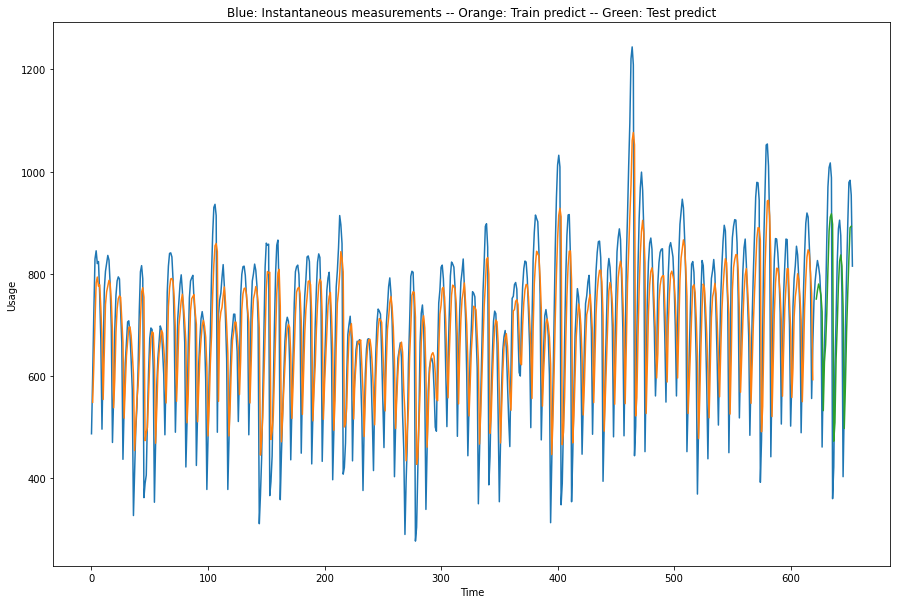

In [288]:
# Plot baseline and predictions

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Blue: Instantaneous measurements -- Orange: Train predict -- Green: Test predict')
plt.ylabel('Usage')
plt.xlabel('Time')
plt.show()

### Why ARIMA?
It is widely used in demand forecasting, such as in determining future demand in food manufacturing. That is because the model provides managers with reliable guidelines in making decisions related to supply chains. ARIMA models can also be used to predict the future price of your stocks based on the past prices

In [295]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

<ipython-input-295-d7c1b8710910>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [296]:
# Split into train and test sets

X = data2.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]

In [303]:
# Walk-forward validation

history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=822.361168, expected=785.000000
predicted=811.243277, expected=808.000000
predicted=801.447714, expected=826.000000
predicted=802.746376, expected=814.000000
predicted=783.989202, expected=796.000000
predicted=767.535548, expected=750.000000
predicted=735.488155, expected=461.000000
predicted=500.480106, expected=608.000000
predicted=694.749982, expected=657.000000
predicted=776.422966, expected=744.000000
predicted=800.506842, expected=865.000000
predicted=873.154701, expected=970.000000
predicted=917.810765, expected=1008.000000
predicted=901.871002, expected=1017.000000
predicted=880.297285, expected=988.000000
predicted=849.478306, expected=360.000000
predicted=316.514472, expected=422.000000
predicted=500.495576, expected=617.000000
predicted=812.305392, expected=714.000000
predicted=833.287540, expected=824.000000
predicted=855.947900, expected=888.000000
predicted=863.924405, expected=905.000000
predicted=839.606038, expected=875.000000
predicted=797.176569, expected=7

In [304]:
# Evaluate forecasts 

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 129.179


### This is our final plotted prediction  
Blue: Instantaneous measurements -- Red: Test prediction

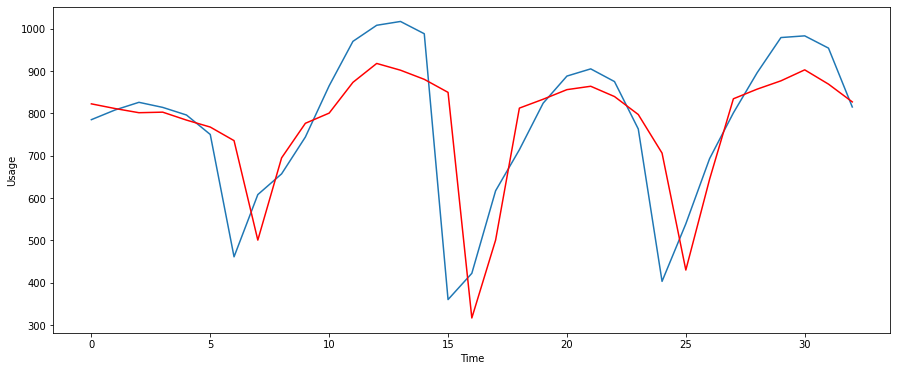

In [308]:
# Plot forecasts against actual outcomes

fig, ax = pyplot.subplots(figsize=(15, 6))
pyplot.plot(test, label='Actual level')
pyplot.plot(predictions, color='red', label='Forecast')
pyplot.xlabel('Time')
pyplot.ylabel('Usage')
pyplot.show()